# **Optimal Agent Behavior in Grid-World Environment Using Q-Learning** 

**General Information**

The code below is designed for a single agent in a square grid world of size n to learn a simple transport task. The agent's task is to pick up the item at location A and deliver it to a fixed target location B. A is not known in advance, ie. it varies each time the agent needs to solve the task. B is the bottom right corner of the grid at coordinates (n,n). The coordinates of A are part of the state information that the agent receives.

The agent starts at a random location. When it reaches location A it automatically picks up the item, when it reaches location B it automatically discharges the item. At this point, it has completed its task.

The agent is allowed to observe its own location, the location of A and whether it carries an item. The task the agent learns is to pick up the load at A and deliver it to B, taking as few steps as possible regardless of its (random) starting position.

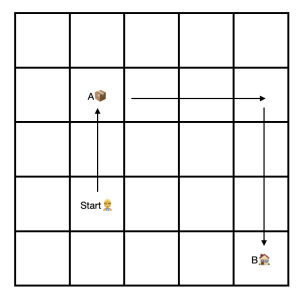

# 1. Documentation:


Features included to ensure that the implementation is easily generalisable to variations of the problem:
- user can pass different grid sizes to GridWorld class
- user can pass different reward structures to GridWorld class
- user can choose to allow agent to move diagonally
- user can pass any number of blocked cells to GridWorld class
- all Q-learning parameters (learning rate, exploration rate, etc.) can be altered as per the user's choice

Metrics used to assess the performance level of the agent's learning:
- success rate over episodes: how often the agent succeeds in completing its task
- total reward over episodes: how reward accumulated by agent improves over time
- Path: shortest path always selected by agent after training, during testing





# 2. Environment:

The GridWorld class below implements a grid world, in which the agent can move and execute its task.


In [1]:
# Environment Module

import numpy as np
import random

class GridWorld:
    def __init__(self, n, reward_move=-1, reward_pick=50, reward_success=100, max_moves=100, allow_diagonal=False, blocked_cells=None):
        """
        Initializes the GridWorld environment.

        Parameters:
        n (int): The size of the grid (n x n).
        reward_move (int): The penalty (or reward) for each movement (default is -1).
        reward_pick (int): The reward for picking up the item (default is 50).
        reward_success (int): The reward for delivering the item to the target (default is 100).
        max_moves (int): The maximum number of allowed moves before the game resets (default is 100).
        allow_diagonal (bool): Flag to allow diagonal moves in the grid (default is False).
        blocked_cells (list of tuples): List of blocked cells' coordinates (default is None).
        """
        self.n = n
        self.state = None
        self.start_state = None
        self.A = None
        self.B = (n-1, n-1)  # The target is fixed at the bottom-right corner
        self.item_picked = False
        self.reward_move = reward_move  # Penalty for movement
        self.reward_pick = reward_pick  # Reward for successfully picking up the item
        self.reward_success = reward_success  # Reward for successfully delivering the item
        self.max_moves = max_moves  # Maximum number of allowed moves
        self.move_count = 0  # Initialize move counter
        self.allow_diagonal = allow_diagonal  # Allow diagonal moves or not
        self.blocked_cells = blocked_cells or []  # Initialize blocked cells


    def reset(self):
        """
        Resets the environment by generating random start positions for the agent and the item A.
        """
        # Initialize agent's position (start state)
        while True:
            self.state = (random.randint(0, self.n-1), random.randint(0, self.n-1))
            if self.state != self.B and self.state not in self.blocked_cells:  # Ensure agent does not start at the target B or the blocked cells
                break
        self.start_state = self.state

        # Initialize item A's position
        while True:
            self.A = (random.randint(0, self.n-1), random.randint(0, self.n-1))
            if self.A != self.B and self.A != self.state and self.A not in self.blocked_cells:  # Ensure A is not at B, agent's start position or blocked cells
                break

        self.item_picked = False
        self.move_count = 0  # Reset move count on environment reset

        # Return the initial observation (agent's position, item's position, item-picked flag)
        return self._get_observation()

    def _get_observation(self):
        """
        Returns the current observation of the environment.

        The observation includes the agent's current position, the item's position,
        and whether the item has been picked up.
        """
        return self.state + self.A + (self.item_picked,)

    def step(self, action):
        """
        Executes the agent's action, updates the environment state, and returns the next state, reward, and done flag.

        Parameters:
        action(int): The action taken by the agent. Possible values:
        0: Move North, 1: Move South, 2: Move West, 3: Move East,
        4: Move North-West (diagonal), 5: Move North-East (diagonal),
        6: Move South-West (diagonal), 7: Move South-East (diagonal).

        Returns:
        tuple: A tuple containing the next state, the reward and a done flag.
        """

        # Get current position of the agent
        x, y = self.state

        # min() prevents agent from overstepping boundary
        if action == 0:   # Move North
            x = max(0, x - 1)
        elif action == 1: # Move South
            x = min(self.n - 1, x + 1)
        elif action == 2: # Move West
            y = max(0, y - 1)
        elif action == 3: # Move East
            y = min(self.n - 1, y + 1)
        elif action == 4: # Move North-West (diagonal)
            x = max(0, x - 1)
            y = max(0, y - 1)
        elif action == 5: # Move North-East (diagonal)
            x = max(0, x - 1)
            y = min(self.n - 1, y + 1)
        elif action == 6: # Move South-West (diagonal)
            x = min(self.n - 1, x + 1)
            y = max(0, y - 1)
        elif action == 7: # Move South-East (diagonal)
            x = min(self.n - 1, x + 1)
            y = min(self.n - 1, y + 1)

        # Check if the next state is a blocked cell
        if (x, y) in self.blocked_cells:
            (x, y) = self.state  # If blocked, remain in the current state

        # Update the agent's position
        self.state = (x, y)
        self.move_count += 1  # Increment move count

        # Initialize reward for this step
        reward = self.reward_move
        done = False

        # Check if the agent has picked the item
        if self.state == self.A and not self.item_picked:
            self.item_picked = True
            reward += self.reward_pick

        # Check if the agent has successfully delivered the item to point B
        if self.state == self.B and self.item_picked:
            reward = self.reward_success
            done = True

        # Check if the agent has exceeded the move limit
        if self.move_count >= self.max_moves:
            done = True  # End the episode
            reward = self.reward_move * self.move_count  # Apply penalty for exceeding the limit

        return self._get_observation(), reward, done

    def action_space(self):
        """
        Returns the size of the action space.

        With diagonal movements, the action space includes eight possible actions:
        North, South, West, East, and the four diagonal directions (North-West, North-East, South-West, South-East).
        Otherwise, it includes only four actions: North, South, West, and East.

        """
        if self.allow_diagonal:
          return 8  # Action space includes the four primary directions and the four diagonals
        return 4  # Action space includes only the four primary directions (no diagonals)

    def state_space(self):
        """
        Returns the size of the state space.
        """
        return self.n * self.n * self.n * self.n * 2  # (x, y, Ax, Ay, item_picked)

# 3. Learning:

The QLearningAgent class implements a table-based Q-Learning algorithm for an agent from scratch.

In [2]:
# Learning Module

class QLearningAgent:
    def __init__(self, env, alpha=0.2, gamma=0.95, epsilon=0.9, epsilon_decay=0.995, min_epsilon=0.01):
        """
        Initializes the Q-learning agent with given parameters and prepares the Q-table.

        Parameters:
        env (GridWorld): The environment in which the agent operates.
        alpha (float): Learning rate (determines the degree to which the Q-value is updated).
        gamma (float): Discount factor (determines the importance of future rewards).
        epsilon (float): Exploration rate (probability of exploring a new action).
        epsilon_decay (float): Decay rate for the exploration rate after each episode.
        min_epsilon (float): Minimum value for the exploration rate (does not decay below this value).
        """

        self.env = env
        self.alpha = alpha  # Learning rate (to determine by how much to update the Q-value based on the newest one)
        self.gamma = gamma  # Discount factor (how important future rewards are)
        self.epsilon = epsilon  # Exploration rate (how often to explore rather than exploit)
        self.epsilon_decay = epsilon_decay  # Decay rate for exploration
        self.min_epsilon = min_epsilon  # Minimum exploration rate (do not decay further after reaching this value)
        self.q_table = np.zeros((env.state_space(), env.action_space()))  # Q-table
        self.rewards = []  # Total rewards for each episode
        self.successes = []  # Records whether the agent succeeded or not

    def _state_to_index(self, state):
        """
        Maps the current state to an index in the Q-table.

        The index is calculated based on the agent's (x, y) position,
        the item's (Ax, Ay) position, and whether the item has been picked.

        Parameters:
        state (tuple): The current state represented by (x, y, Ax, Ay, item_picked).

        Returns:
        The corresponding index (int) in the Q-table for the given state.
        """
        x, y, ax, ay, item_picked = state
        return (x * self.env.n + y) * (self.env.n ** 2) * 2 + (ax * self.env.n + ay) * 2 + item_picked

    def choose_action(self, state):
        """
        Chooses an action using an epsilon-greedy policy.

        The agent either explores by choosing a random action with probability epsilon,
        or exploits the learned Q-values by selecting the action with the highest Q-value.

        Parameters:
        state (tuple): The current state of the environment.

        Returns:
            The selected action (int) based on the epsilon-greedy strategy.
        """

        # Choose to explore
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.env.action_space() - 1)

        # Or choose to exploit
        state_index = self._state_to_index(state)
        return np.argmax(self.q_table[state_index])  # Selects the best action based on the Q-table

    def learn(self, state, action, reward, next_state):
        """
        Updates the Q-table based on the Q-learning update rule:
        Q(S, A) ← Q(S, A) + α (R + 𝛾 max Q(S′, a′) − Q(S, A))

        This updates the Q-value for the current state-action pair based on the reward and
        the best possible future reward from the next state.

        Parameters:
        state (tuple): The current state of the environment.
        action (int): The action taken by the agent in the current state.
        reward (float): The reward received after taking the action.
        next_state (tuple): The state the environment transitions to after the action.
        """

        state_index = self._state_to_index(state)  # Convert current state to index
        next_state_index = self._state_to_index(next_state)  # Convert next state to index

        # Select the best possible next action based on the highest Q-value in the next state
        best_next_action = np.argmax(self.q_table[next_state_index])

        td_target = reward + self.gamma * self.q_table[next_state_index][best_next_action] #new Q-value
        td_error = td_target - self.q_table[state_index][action] # minus old Q-value

        # Update Q-value rather than completely discard old Q-value
        self.q_table[state_index][action] += self.alpha * td_error  # Update Q-value in the Q-table


# 4. Training and Testing:

The two functions below allow for the training and testing of the agent.


In [3]:
# Training & Testing Module

def train(agent, episodes):
    """
    Trains the Q-learning agent over a specified number of episodes.

    For each episode, the environment is reset, and the agent interacts with the environment
    by selecting actions based on its current Q-table and exploration strategy (epsilon-greedy).
    The Q-table is updated after each action based on the received reward, and the total reward
    for the episode is recorded. The epsilon value is decayed after each episode to reduce exploration
    over time.

    Parameters:
    agent (QLearningAgent): The Q-learning agent to be trained.
    episodes (int): The number of training episodes to run.
    """

    for episode in range(episodes):
        state = agent.env.reset()  # Reset environment to start a new episode
        done = False
        total_reward = 0
        success = 0  # Records whether the task was successfully completed

        # Loop through the episode until completion
        while not done:
            action = agent.choose_action(state)  # Agent selects an action based on epsilon-greedy policy
            next_state, reward, done = agent.env.step(action)  # Execute the action in the environment
            agent.learn(state, action, reward, next_state)  # Update the Q-table using the Q-learning update rule
            state = next_state  # Move to the next state
            total_reward += reward  # Accumulate reward for the episode

            # Check if the task was successfully completed
            if done and reward == agent.env.reward_success:
                success = 1  # Task successfully completed

        # Record total reward and success status
        agent.rewards.append(total_reward)
        agent.successes.append(success)

        # Decay epsilon
        agent.epsilon = max(agent.min_epsilon, agent.epsilon * agent.epsilon_decay)

def test(agent):
    """
    Tests the agent's performance by running a single episode using the learned Q-table.

    The agent follows the policy derived from the Q-table (exploitation only, no exploration)
    to complete the task. The function returns the sequence of states (the path) that the agent
    traversed during the episode.

    Parameters:
    agent (QLearningAgent): The Q-learning agent to be tested.

    Returns:
    path (list): A list of states representing the path the agent took from start to end during the test episode.
    """

    state = agent.env.reset()
    done = False
    path = [state]

    while not done:
        action = agent.choose_action(state)
        state, _, done = agent.env.step(action)
        path.append(state)

    return path


# 5. Visualisation:

The functions below allow the user to visualise how the agent learns the task.

In [4]:
# Visualization Module
### To visualise agent during training

import matplotlib.pyplot as plt

def plot_rewards(rewards):
    """
    Visualizes the total rewards earned by the agent over all episodes.

    Parameters:
    rewards (list of float): The total rewards obtained by the agent in each episode.
    """

    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title('Total Rewards Over Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.grid(True)  # Add gridlines for better readability
    plt.show()

def plot_success_rate(successes, episodes):
    """
    Visualizes the success rate of the agent over episodes using a sliding window.

    The success rate is smoothed using a sliding window to make trends more visible.

    Parameters:
    successes(list of int): A list of binary values indicating whether the agent successfully completed the task in each episode (1 for success, 0 for failure).
    episodes (int): The total number of episodes.
    """

    plt.figure(figsize=(10, 5))
    window = 100  # Sliding window size
    success_rate_smoothed = np.convolve(successes, np.ones(window)/window, mode='valid')
    plt.plot(range(window, episodes+1), success_rate_smoothed, color='red')
    plt.title('Success Rate Over Episodes (Sliding Window)')
    plt.xlabel('Episodes')
    plt.ylabel('Success Rate')
    plt.grid(True)  # Add gridlines
    plt.show()


In [5]:
# Visualization Module
### To visualise agent's path before/after training

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle, Rectangle
import numpy as np
from IPython.display import Image, display

def animate_path(path, n, item_A, target_B, start_pos, blocked_cells=None, filename="gridworld_animation.gif"):
    """
    Creates and saves an animated visualization of the agent's path in the grid world.

    Parameters:
    - path (list of tuples): A sequence of positions representing the agent's path over time.
                             Each element is a tuple (x, y) representing the agent's position in the grid.
    - n (int): The size of the grid (n x n).
    - item_A (tuple): Coordinates (x, y) of item A in the grid.
    - target_B (tuple): Coordinates (x, y) of the target location B in the grid.
    - start_pos (tuple): Coordinates (x, y) of the agent's starting position in the grid.
    - blocked_cells (list of tuples, optional): Set of blocked cells' coordinates in the grid.
    - filename (str, optional): The filename to save the animation as a GIF. Defaults to "gridworld_animation.gif".

    Returns:
    - Displays the animated GIF showing the agent's movement from start to finish within the grid.
    """

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(0, n)
    ax.set_ylim(n, 0)

    # Set grid lines
    ax.set_xticks(np.arange(0, n, 1))
    ax.set_yticks(np.arange(0, n, 1))
    ax.grid(True)

    # Draw the blocked cells
    if blocked_cells:
        for cell in blocked_cells:
            ax.add_patch(Rectangle((cell[1], cell[0]), 1, 1, color='black', alpha=0.5))
            # Add the "No Access" text at the center of the blocked cell
            ax.text(cell[1] + 0.5, cell[0] + 0.5, 'No Access', color='white',ha='center', va='center', fontsize=10, fontweight='bold')

    # Mark the positions of item A, target B and agent's starting position
    ax.add_patch(Rectangle((item_A[1]+0.2, item_A[0]+0.2), 0.6, 0.6, color='blue', label='Item A'))
    ax.add_patch(Circle((target_B[1]+0.5, target_B[0]+0.5), 0.35, color='green', label='Target B'))
    ax.add_patch(Circle((start_pos[1]+0.5, start_pos[0]+0.5), 0.35, color='orange', label='Start Position'))

    # Add text labels to the patches
    ax.text(item_A[1]+0.5, item_A[0]+0.5, 'A', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
    ax.text(target_B[1]+0.5, target_B[0]+0.5, 'B', color='white', ha='center', va='center', fontsize=12, fontweight='bold')
    ax.text(start_pos[1]+0.5, start_pos[0]+0.5, 'Start', color='white', ha='center', va='center', fontsize=12, fontweight='bold')

    # Initial position of the agent
    agent_marker, = ax.plot([], [], 'ro', markersize=10)

    # List to hold visited positions
    visited_positions = []

    def update(frame):
        """
        Update the agent's position for each frame of the animation.

        Parameters:
        - frame (int): The current frame index, corresponding to the agent's step in the path.

        Returns:
        - A tuple of objects that are updated in the plot (agent's position and visited positions).
        """

        # Get the current state
        current_position = path[frame][:2]

        # Update agent's position
        agent_marker.set_data([current_position[1] + 0.5], [current_position[0] + 0.5])

        # Mark visited positions with a small dot
        visited_positions.append(ax.plot(current_position[1] + 0.5, current_position[0] + 0.5, 'ko', markersize=3)[0])

        return agent_marker, *visited_positions

    # Create the animation
    anim = animation.FuncAnimation(fig, update, frames=len(path), interval=300, blit=True, repeat=False)

    # Save the animation as a GIF
    anim.save(filename, writer='pillow')

    plt.legend(loc='upper left')
    plt.close(fig)  # Close the figure to prevent it from displaying twice in Colab

    # Display the GIF
    display(Image(filename=filename))



# 6. Implementation:

Below is the code implementation for two different scenarios.

Testing the agent before training...


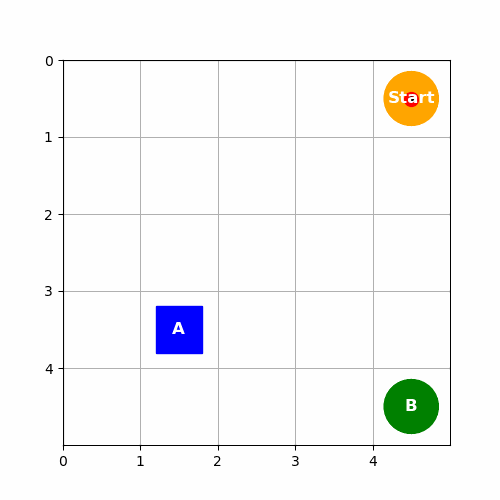

Training the agent for 2000 episodes...


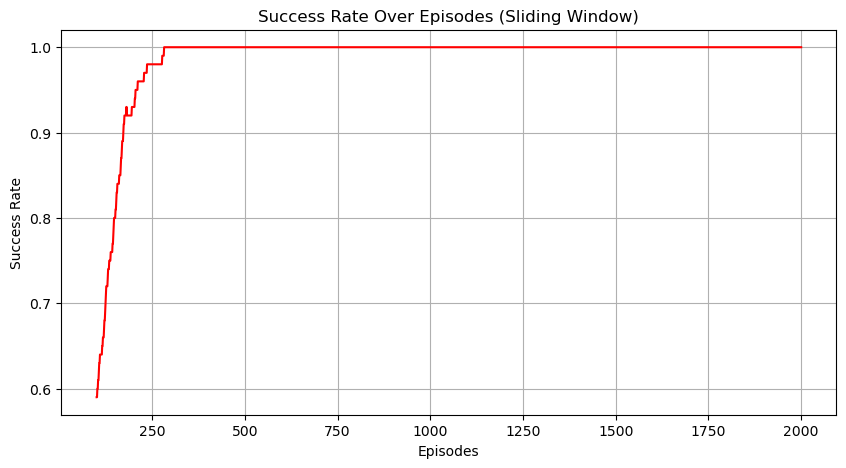

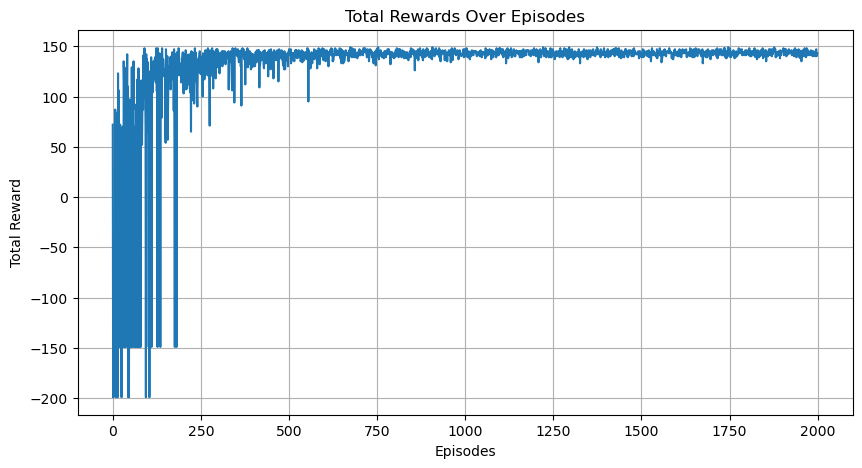

Training complete. Final epsilon: 0.01
Number of successes: 1952 / 2000
Total reward: 264307
Testing the agent after training...


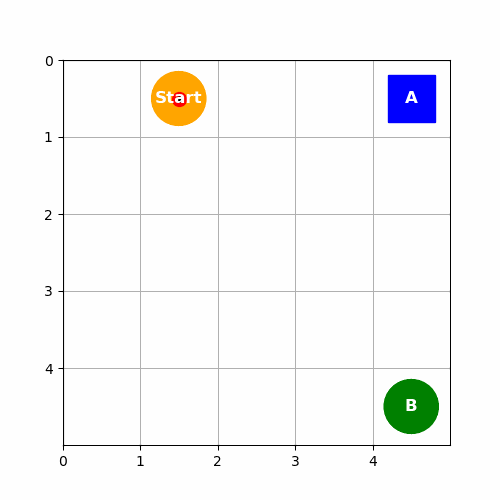

In [6]:
n = 5  # Grid size
episodes = 2000  # Number of training episodes

# Initialize environment and agent
env = GridWorld(n)
agent = QLearningAgent(env)

# Test the agent before training and visualize the path
print("Testing the agent before training...")
path = test(agent)
animate_path(path, n, env.A, env.B, env.start_state, filename="gridworld_animation.gif")

# Train the agent:
print(f"Training the agent for {episodes} episodes...")
train(agent, episodes)

# Visualize the success rate curve
plot_success_rate(agent.successes, episodes)

# Visualize the reward curve
plot_rewards(agent.rewards)

# Summary after training
print(f"Training complete. Final epsilon: {agent.epsilon}")
print(f"Number of successes: {sum(agent.successes)} / {episodes}")
print(f"Total reward: {sum(agent.rewards)}")

# Test the agent after training and visualize the path
print("Testing the agent after training...")
path = test(agent)
animate_path(path, n, env.A, env.B, env.start_state, filename="gridworld_animation.gif")



Testing the agent before training...


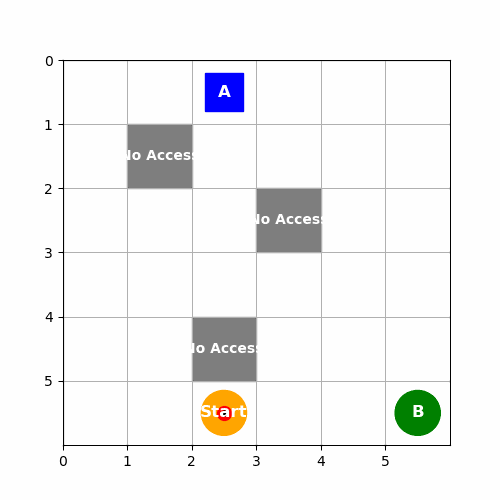

Training the agent for 2000 episodes...


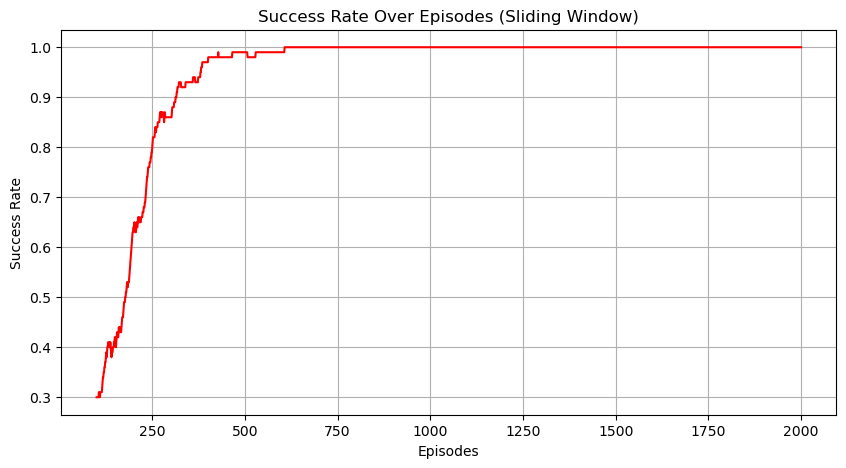

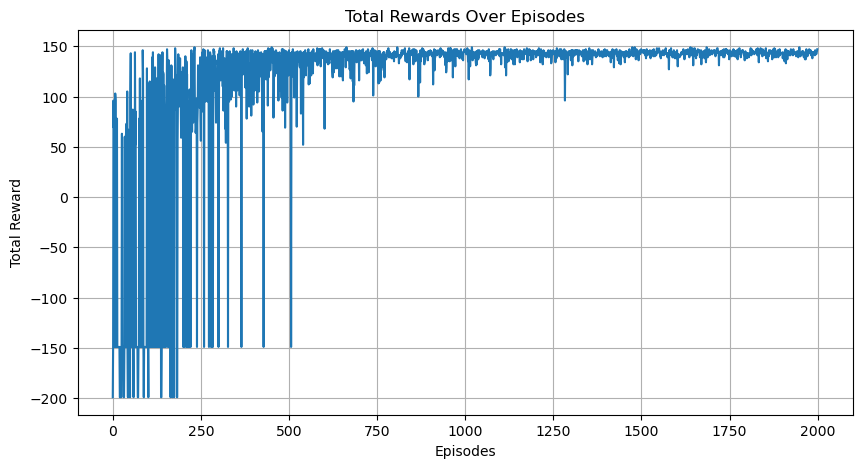

Training complete. Final epsilon: 0.01
Number of successes: 1875 / 2000
Total reward: 236516
Testing the agent after training...


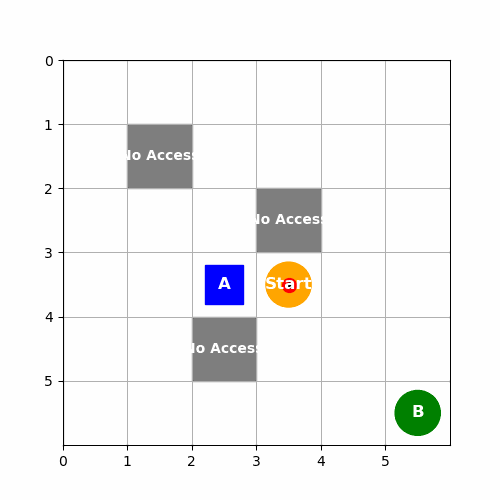

In [7]:
# Training with 6x6 grid size, blocked cells and diagonal actions allowed - to show generalisability of code

n = 6  # Grid size
episodes = 2000  # Number of training episodes

#added
blocked_cells = [(1, 1), (2, 3), (4, 2)]
# Initialize environment and agent
env = GridWorld(n, allow_diagonal=True, blocked_cells=blocked_cells)
agent = QLearningAgent(env)

# Test the agent before training and visualize the path
print("Testing the agent before training...")
path = test(agent)
animate_path(path, n, env.A, env.B, env.start_state, blocked_cells=blocked_cells, filename="gridworld_animation_before_training.gif")

# Train the agent:
print(f"Training the agent for {episodes} episodes...")
train(agent, episodes)

# Visualize the success rate curve
plot_success_rate(agent.successes, episodes)

# Visualize the reward curve
plot_rewards(agent.rewards)

# Summary after training
print(f"Training complete. Final epsilon: {agent.epsilon}")
print(f"Number of successes: {sum(agent.successes)} / {episodes}")
print(f"Total reward: {sum(agent.rewards)}")

# Test the agent after training and visualize the path
print("Testing the agent after training...")
path = test(agent)
animate_path(path, n, env.A, env.B, env.start_state, blocked_cells=blocked_cells,filename="gridworld_animation_after_training.gif")
